<h6> Solution created by Shay Halfon </h6>

<font color="dark"> <h1 align='center'> Part A </h1> </font>

In [1]:
#Imports
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib
warnings.filterwarnings("ignore")

<font color="blue" > <h3 align='left'> Part A.1-6 </h3> <h5> Basic Operations </h5> </font>

In [2]:
def get_total_rows(df):
    '''
    :param df: pd.Dataframe in format_1
    :return: int
    '''
    return df.shape[0]

def get_sorted_columns(df):
    '''
    :param df: pd.Dataframe in format_1
    :return: list
    '''
    return sorted(df.columns)

def count_unique_values(df):
    '''
    :param df: pd.Dataframe in format_1
    :return: pd.Series
    '''
    return pd.Series(df.nunique( dropna = False))
# we want to count the NA also thats why we dont drop them.

def get_index_as_list(df, column_index):
    '''
    :param df: pd.Dataframe in format_1
    :param column_index: boolean, if True returns the column index, otherwise, the row index
    :return:
    '''
    if column_index:
        return list(df.columns)
    return list(df.index)

def find_min_year(df):
    '''
    computes the earliest year in df
    :param df: pd.Dataframe in format_1
    :return: np.int64
    '''
    return df.Year.min()

def apply_func_over_numric_columns(df, columns, fun):

    '''
    applies function fun over the columns of df
    :param df:  df: pd.Dataframe in format_1
    :param columns: list of columns that fun should be applied over
    :param fun: a numpy function from the following list:
        np.prod, np.std ,np.var , np.sum , np.min, np.max, np.mean , np.median
    :return: a pd.Series: its index is columns; its values if the result of applying fun over the selected columns;
    '''
    fun_ls = [np.prod, np.std, np.var,np.sum, np.min, np.max, np.mean, np.median]
            
    for x in columns:
        if x not in df.columns:
            raise ValueError("The specified column is missing from the dataframe")
        if not np.issubdtype(df[x], np.number):
            raise ValueError("The specified column must be numeric")

    if not fun in fun_ls:
        raise ValueError("Invalid function! function must be one \
                of np.prod, np.std, np.var, np.sum, np.min, np.max, np.mean, np.median")
 
    return pd.Series(data = [fun(df[x]) for x in columns], index = columns)

<font color="dark"> <h1 align='center'> Part B </h1> </font><font color="blue"> <h5> Reshaping </h5></font>

In [3]:
def helper(df_left,df_right,name):
    # merging imports and exports
    df_h = pd.merge(left =df_left, right=df_right,on=['Area','Item','Year'],how='inner' )
    #dropping un-needed columns:
    df_h = df_h.drop(['Element_y','Element_x'],axis = 1)
    
    df_h['Element'] = name
    #chaning the column names:
    df_h.columns = ['Area','Item','Year','Quantity(tons)','Price(k,usd)','Element']
    
    return df_h


def reshape(df):
    '''
    The function joins rows that share ('area', 'item', 'year')
    if they are of export type or of import type, see desc. in pdf.
    Rows that only have a single export / import values are removed;
    :param df: pd.Dataframe of format_1
    :return: a pd.Dataframe of format_2
    '''       
    #drop the unit column and check
    df = df.drop(['Unit'], axis=1) # drop unit column
    #df.head()
       
    #group by element
    grouped = df.groupby("Element")
       
     #Seperate into DF
    df_Import_Quantity = grouped.get_group('Import Quantity')
    df_Import_Value = grouped.get_group('Import Value')
    df_Export_Quantity = grouped.get_group('Export Quantity')
    df_Export_Value = grouped.get_group('Export Value')
       
     # changing element column to import/ export
    
    df_Import_Quantity.loc[:,'Element'] = 'Import'
    df_Import_Value.loc[:,'Element'] = 'Import'
    df_Export_Quantity.loc[:,'Element'] = 'Export'
    df_Export_Value.loc[:,'Element'] = 'Export'
    
    df_import = helper(df_Import_Quantity,df_Import_Value,'Import')
    df_export = helper(df_Export_Quantity,df_Export_Value,'Export')
    
      # appending the df together
    frames = [df_import,df_export]
    return pd.concat(frames)

In [4]:
#function to check if we did the reshape correctly
def validate(df):

    assert(df.shape == (5128759, 6))
    assert(pd.Series(df.columns == pd.Index(['Area', 'Item', 'Year', 'Quantity(tons)', 'Price(k,usd)', 'Element'],
                                      dtype='object')).all())

In [5]:
if __name__ == '__main__':

    # PART A
    df = pd.read_pickle('data.pickle') ## 'data_projected.pickle'

    # A. 1
    total_rows = get_total_rows(df)
    print(total_rows)
    # A. 2
    columns_sorted = get_sorted_columns(df)
    print(columns_sorted)
    # A. 3
    columns_sums_ = count_unique_values(df)
    print(columns_sums_)
    # A. 4
    res1 = get_index_as_list(df, True)
    res2 = get_index_as_list(df, False)
    
    # A. 5
    year = find_min_year(df)
    # A. 6
    columns = ["Value", "Year"]
    year_value_means = apply_func_over_numric_columns(df, columns, np.mean)
    print('A6a', year_value_means)
    
    columns = ["Year"]
    max_val = apply_func_over_numric_columns(df, columns, np.max)
    print('A6b', max_val)

    # PART B
    df_r = reshape(df)
    validate(df_r)
    pd.to_pickle(df_r, "fixed_df.pickle")

10418605
['Area', 'Element', 'Item', 'Unit', 'Value', 'Year']
Area          210
Item          436
Element         4
Year           53
Unit            2
Value      313641
dtype: int64
A6a Value    30855.756797
Year      1987.901231
dtype: float64
A6b Year    2013
dtype: int64


<font color="dark"> <h1 align='center'> Part C </h1> </font><font color="blue"> <h5> Filter and GroupBy </h5></font>

In [6]:
def find_most_frequent_year(df, n):
    '''
    :param df: pd.Dataframe
    :param n: positive, integer;  n'th most frequent year
    :return: int; the n'th most frequent year
    :raise: ValueError - if n is not a positive int
    '''
    if n<=0 or (not isinstance(n,int)): # to be sure n is integer
        raise ValueError ("n must be a strictly positive integer (>0)")
       
    return df['Year'].value_counts().index[n-1]

def filterby_criteria(df, criteria):
    '''
    critirea =  {"Element": ["Export"], "Year":[2013]}
        The function filters all rows that do not have values
        that are included in the dict criteria
    :param df: pd.dataframe of in format_2
    :param criteria: a dictionary mapping columns to values to keep;
    key – is a column name; values is a values list
    :return: a df without the rows that do not include the specified values
    :raise: ValueError if key is not in dataframe
    '''

    if not criteria:
        return df
    for x,y in sorted(criteria.items()):
        if x not in df.columns:
            raise ValueError(x + " is not a column in df")
        df = df[df[x].isin(y)] #filter each column X with the values Y
    return df

def find_extremes(df, fun=np.sum, by_item=True, by_value=True, n=5):
    '''
    :param df: pd.DataFrame in format_2; only including importing/exporting rows
    :param by_item: If True group rows by item, otherwise by Area
    :param by_value: If True should find the n most extreme items by value, otherwise by quantity
    :param fun:  a function to be applied, one of: np.prod(),np.std(),np.var(),
    np.sum(), np.min(), np.max(), np.mean(), np.median()
    :param n: if positive get the least extreme item, otherwise, get the most
    :return: list of the n least/most imported/exported items
    raise: ValueError if n is not an int != 0
    raise: ValueError df contains both import and export values
    raise: ValueError fun is not one of the specified above functions
    '''
    if not np.issubdtype(type(n), np.number) or n==0:
        raise ValueError("n must be an integer different than zero")

    if len(df['Element'].unique())!=1:
        raise ValueError("The dataframe must only include Import or Export rows")
    
    if fun not in [np.prod,np.std,np.var, np.sum, np.min, np.max, np.mean, np.median]:
        raise ValueError("Invalid function! function must be one of np.prod(),np.std(),np.var(), np.sum(), np.min(), np.max(), np.mean(), np.midian()")
    
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    

    if by_item:
        grouped = df.groupby("Item")
    else:
        grouped = df.groupby('Area')
        
    if by_value:
        ls = grouped['Price(k,usd)'].aggregate(fun).sort_values()
    else:
        ls = grouped['Quantity(tons)'].aggregate(fun).sort_values()
        
    if n<0:
        return list(ls.index[n:])
    else:
        return list(ls.index[:n])
    

def generate_scatter_import_vs_export(df, countries, year, output):
    '''
    The function produces a scatter plot of the total import/export values of the specified countries in the specified year
    :param df: a dataframe in format_2
    :param countries: a list of strings specifying countries
    :param year: int; only rows of the specified year are used
    :param output: a filename (str) to which the scatter plot is to be saved
    :return: None; saves the plot to output.png
    '''


    df= df[df['Area'].isin(countries)]
    df_exp = filterby_criteria(df, {"Element": ["Export"], "Year":[year]})
    df_imp = filterby_criteria(df, {"Element": ["Import"], "Year":[year]})
    
    y = df_exp.groupby('Area')['Quantity(tons)'].aggregate(np.sum)
    x = df_imp.groupby('Area')['Quantity(tons)'].aggregate(np.sum)

    plt.subplots(figsize=(10,6))
    cmap = matplotlib.cm.get_cmap('RdYlGn')
    plt.axes(xscale='log', yscale='log')
    
    
    t = cmap(y/x)
    size = (y+x)
    normal_size = (size-size.min())/(size.max()-size.min())*100
    normal_size += 20
    
    plt.scatter(x, y,c=t, cmap = cmap,s=normal_size )
    plt.title('Exports as function of imports')
    plt.xlabel('Imports')
    plt.ylabel('Exports')
    
    
    for i, txt in enumerate(sorted(countries)):
        plt.annotate(txt,(x[i],y[i]), verticalalignment='bottom', size = 'large')
    plt.savefig(output+".png") #cant put show before savefig
    #plt.close()
 
    return

In [7]:
if __name__ == '__main__':

    LN_SEP = "\n---------------------------------------------"

    df = pd.read_pickle("fixed_df.pickle")
    # PART C
    # C. 1
    year1 = find_most_frequent_year(df, 10)
    year2 = find_most_frequent_year(df, 4)
    print('year1, year2:', year1, year2)

    # PART C
    # C. 2
    df_isr75_export = filterby_criteria(df, {"Area": ["Israel"], "Year": [1975], "Element":["Export"]})
    df_isr13_export = filterby_criteria(df, {"Area": ["Israel"], "Year": [2013], "Element": ["Export"]})

    # PART C
    
    # C. 3
    most_items = find_extremes(df_isr75_export, by_item=True, by_value=True, n=-5)
    print("most exported items from israel 2013 by value:\n", "\n".join(most_items), LN_SEP)
    most_items = find_extremes(df_isr13_export, by_item=True, by_value=False, n=-5)
    print("most exported items from israel 2013 by quantity:\n", "\n".join(most_items), LN_SEP)

    df_exp = filterby_criteria(df, {"Element": ["Export"], "Year":[2013]})
    df_imp = filterby_criteria(df, {"Element": ["Import"], "Year":[2013]})

    most_exp_countries = find_extremes(df_exp, by_item=False, by_value=True, n=-12)
    most_imp_countries = find_extremes(df_imp, by_item=False, by_value=True, n=-12)
    countries = list(set(most_exp_countries + most_imp_countries))

    print("List of countries that import and export the most by value:\n","\n".join(countries), LN_SEP)
    

year1, year2: 2000 2007
most exported items from israel 2013 by value:
 Textile Fibres
Grapefruit (inc. pomelos)
Oth Citrus Frt
Oranges+Tang+Clem
Oranges 
---------------------------------------------
most exported items from israel 2013 by quantity:
 Oth Citrus Frt
Oranges+Tang+Clem
Chillies and peppers, green
Carrots and turnips
Potatoes 
---------------------------------------------
List of countries that import and export the most by value:
 France
Brazil
Mexico
Italy
Japan
China
Germany
Russian Federation
United Kingdom
Canada
Spain
Belgium
Netherlands
Indonesia
Argentina
Australia
India
United States of America 
---------------------------------------------


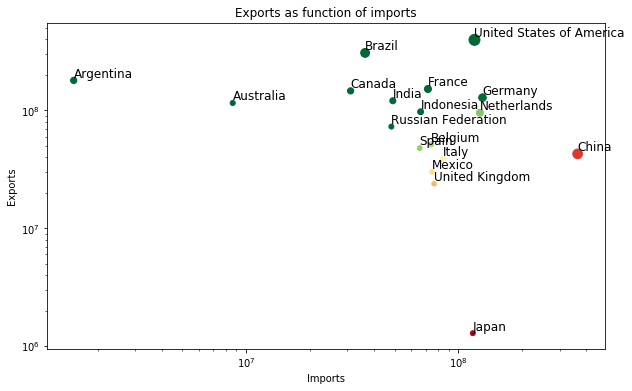

In [8]:
generate_scatter_import_vs_export(df, countries=countries, year=2013, output='import_vs_export')